<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/web_%24%26_human_in_the_loop_interrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
!pip install --upgrade langchain langchain_google_genai langgraph tavily-python langchain_community langchain_core

In [ ]:
import os
from google.colab import userdata
Gemnai_api_key = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI (
    model = "gemini-pro",  # Changed the model name to a valid model identifier
    api_key = Gemnai_api_key
)
llm.invoke("i am hafiz naveed uddin from karachi")

AIMessage(content="Hello Hafiz Naveed Uddin from Karachi! It's nice to meet you. I hope you are having a great day. If you have any questions or need any assistance, please feel free to ask. I'm here to help.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fe23f5ae-af70-4ad2-a860-655088768ae8-0', usage_metadata={'input_tokens': 12, 'output_tokens': 50, 'total_tokens': 62, 'input_token_details': {'cache_read': 0}})

In [ ]:
LANGCHAIN_API_KEY = userdata.get('memory-enabled-agent')  # LangSmith API key

# Configure environment variables for LangChain and LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable LangSmith tracing
os.environ["LANGCHAIN_PROJECT"] = "memory-enabled-agent"  # Set LangSmith project name
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY  # Set LangSmith API key

In [ ]:
import os
from google.colab import userdata

# ... (other imports)

# Get the Tavily API key
tavily_api_key = userdata.get("Tavily_Api_Key")

# Set the environment variable with the actual API key value
os.environ["TAVILY_API_KEY"] = tavily_api_key  # Use correct environment variable name

# ... (other code)

from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the tool with the API key
# Using the environment variable, no need to pass it directly
tool = TavilySearchResults(max_results=2)
# Alternatively, pass directly: tool = TavilySearchResults(tavily_api_key=tavily_api_key, max_results=2)

tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [ ]:
llm_with_tools=llm.bind_tools(tools)

In [ ]:
response = llm_with_tools.invoke("what is langgraph?")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavilly_search_results_json (ed743859-1bc6-400e-9f39-c587dfb51ab4)
 Call ID: ed743859-1bc6-400e-9f39-c587dfb51ab4
  Args:
    query: what is langgraph


In [ ]:
from langgraph.graph import START, END , StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
from langgraph.graph.message import MessagesState

In [ ]:
def llm (state:MessagesState)->MessagesState:
  return{"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
builder:StateGraph=StateGraph(MessagesState)
builder.add_node("llm",llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START, "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools","llm")

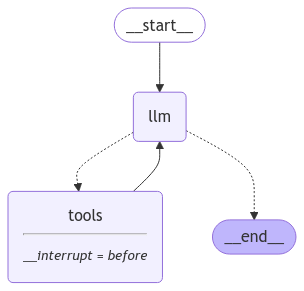

In [ ]:
graph: CompiledStateGraph = builder.compile(checkpointer=memory, interrupt_before=["tools"])

# Display graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
from langchain.schema.messages import ToolMessage, HumanMessage, AIMessage  # Import from langchain.schema.messages


In [ ]:
config2 = {"configurable": {"thread_id": "2"}} # Changed config1 to a dictionary with the correct structure
message = graph.invoke({"messages":[HumanMessage(content = "i m learning Generative ai")]}, config2)
for m in message["messages"]:
  m.pretty_print()


================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22)
 Call ID: 8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22
  Args:
    query: What is generative AI


In [ ]:
snapshot =graph.get_state(config2)
snapshot.next


('tools',)

In [ ]:
m = snapshot.values["messages"][-1]
m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22)
 Call ID: 8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22
  Args:
    query: What is generative AI


In [ ]:
m.tool_calls[0]["args"]["query"] = "LangGraph human-in-the-loop workflow"

# Then create your new_message with the updated tool_call
new_message = AIMessage(
    content=m.content,
    tool_calls=m.tool_calls,  # Use the updated tool_calls from 'm'
    id=m.id,
)

# The rest of your code remains the same
graph.update_state(config2, {"messages": [new_message]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb20d3-ad9e-60ca-8002-b1cfa210bd4a'}}

In [ ]:
for m in graph.get_state(config2).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

i m learning Generative ai
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22)
 Call ID: 8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://www.js-craft.io/blog/langgraph-human-loop-javascript/", "content": "This is part 2 of the series dedicated to using Human In The Loop mechanisms in LangGraph. You can find the first part here - Human-in-the-Loop in LangGraph. Example Setup A common Human In The Loop

In [ ]:
events = graph.stream(None, config2, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22)
 Call ID: 8e9ae2e1-5a3a-41ed-8495-2776ca3dfa22
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://www.js-craft.io/blog/langgraph-human-loop-javascript/", "content": "This is part 2 of the series dedicated to using Human In The Loop mechanisms in LangGraph. You can find the first part here - Human-in-the-Loop in LangGraph. Example Setup A common Human In The Loop (HITL) interaction pattern involves the AI agent pausing to request human input, allowing for clarification 